Import the required packages and set up the Spark session with spark-nlp.

In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2022-12-08 21:24:28--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-12-08 21:24:29--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-12-08 21:24:30--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [2]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 4.2.4
Apache Spark version: 3.2.1


Load the CSV file (n=1000 samples) containing our manual labels as the target vector

In [3]:
from google.colab import files
uploaded = files.upload()

Saving GH-React.csv to GH-React.csv


In [4]:
from pyspark.sql.functions import col
df = (spark.read
  .format("csv")
  .option("header", "true")
  .option("inferSchema", "true")
  .option("multiline", "true")
  .option("quote", '"')  
  .option("escape", "\\")
  .option("escape", '"')
  .load("GH-React.csv")
)
df = df.select(col('title'), col('author_association'), col('body'), col('Target'))

In [5]:
# a helper function to get the shape of a Spark DF
def sparkdf_shape(df):
  return df.count(), len(df.columns)

In [6]:
print("Shape:", sparkdf_shape(df))

Shape: (1000, 4)


## Machine Learning Pipeline

### Stage 1
Split the data into training (80%) and validation(20%) sets. We will stratify based on the label since our dataset is imbalanced.

In [7]:
# create a stratified sample for the training set using a 0.8 ratio
train = df.stat.sampleBy("Target", fractions={"Bug":0.8, "Feature":0.8, "Support": 0.8, "Other": 0.8}, seed=2)
validate = df.exceptAll(train)

In [9]:
print("training set size:",train.count())
print("validation set size:",validate.count())

training set size: 799
validation set size: 201


### Stage 2
The strip_text() function is defined below. It takes in a String formatted as Markdown from GitHub and pre-processes it to return a new string ready for the next stages in our ML Pipeline.

In [10]:
import re
from pyspark.sql.functions import udf

@udf("String")
def strip_text(text):
  if text is not None:
    stripped = text.lower()    

    # remove all headings, bold text, and HTML comments from the Markdown text.
    # These items have all been used by the React team in their issue templates on GitHub
    headings_pattern = r'(<=\s|^)#{1,6}(.*?)$'
    bold_pattern = r'\*\*(.+?)\*\*(?!\*)'
    comments_pattern = r'<!--((.|\n)*?)-->'
    combined_pattern = r'|'.join((headings_pattern, bold_pattern, comments_pattern))

    stripped = re.sub(combined_pattern, '', stripped)

    # find all URLs in the string, and then remove the final directory from each to leave the general URL form
    # there may be useful patterns based on what URLs issues are commonly linking to
    url_pattern = re.compile(r'(https?://[^\s]+)')
    for url in re.findall(url_pattern, stripped):
        new_url = url.rsplit("/", 1)[0]
        stripped = stripped.replace(url, new_url)

    non_alpha_pattern = r'[^A-Za-z ]+'
    stripped = re.sub(non_alpha_pattern, '', stripped)    
    
    return ' '.join(stripped.split())
  else:
    return " "

Apply the strip_text() function to both the title and body columns in the train and validation datasets

In [11]:
train_data = train.withColumn("body", strip_text(col("body"))).withColumn("title", strip_text(col("title")))
validation_data = validate.withColumn("body", strip_text(col("body"))).withColumn("title", strip_text(col("title")))

Check that the strip_text() function worked as expected on one sample:

In [12]:
train_data.take(1)

[Row(title='reactnativecustomtabs not return response', author_association='NONE', body='i have created button to open custontabs to use external url into reactnative app external url have some forms that are submitted and return array as a response into another page ie success page i want to get response from success page into app and customtabs would be close automatically code for custom taburl httpswwwexamplecomcustomtabsopenurlurl toolbarcolor dbenableurlbarhiding trueshowpagetitle trueenabledefaultshare trueanimations animationsslidethenlaunched boolean consoleloglaunched custom tabs launchedcatcherr consoleerrorerr', Target='Feature')]

### Stage 3
Create a TF-IDF features vector using a PySpark Pipeline. We will use TF-IDF applied to stemmed ngrams from both the issue title and body columns. We wi

We will apply this step separately to both the body and title to produce a different set of features for each. The tokens in the title may hold different importance than the same token in the body.

We will additionally add in the feature 'author_association' from the GitHub issue, as there may be a correlation between Members/Collaborators/Contributors submitting more valid bugs/feature requests than "None" users. This will be applied using one-hot-encoder.

In [13]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [16]:
# NLP Pipeline
documentAssemblerTitle = DocumentAssembler().setInputCol('title').setOutputCol('titles')
documentAssemblerBody = DocumentAssembler().setInputCol('body').setOutputCol('bodies')
tokenizer_titles = Tokenizer().setInputCols(['titles']).setOutputCol('tokenized_titles')
tokenizer_bodies = Tokenizer().setInputCols(['bodies']).setOutputCol('tokenized_bodies')
lemmatizer_titles = LemmatizerModel.pretrained().setInputCols(['tokenized_titles']).setOutputCol('trunc_titles')
lemmatizer_bodies = LemmatizerModel.pretrained().setInputCols(['tokenized_bodies']).setOutputCol('trunc_bodies')
ngrammer_titles = NGramGenerator().setInputCols(['trunc_titles']).setOutputCol('ngrams_titles').setN(2).setEnableCumulative(True)
ngrammer_bodies = NGramGenerator().setInputCols(['trunc_bodies']).setOutputCol('ngrams_bodies').setN(2).setEnableCumulative(True)
finisher = Finisher().setInputCols(['ngrams_titles','ngrams_bodies'])

tf_titles = CountVectorizer(inputCol='finished_ngrams_titles',outputCol='tf_features_titles')
tf_bodies = CountVectorizer(inputCol='finished_ngrams_bodies',outputCol='tf_features_bodies')
idf_titles = IDF(inputCol='tf_features_titles', outputCol='idf_titles',minDocFreq=5)
idf_bodies = IDF(inputCol='tf_features_bodies', outputCol='idf_bodies',minDocFreq=5)
author_stringIdx = StringIndexer(inputCol="author_association", outputCol="author_index")
ohe = OneHotEncoder(inputCol="author_index", outputCol="aa")
assembler = VectorAssembler(inputCols=['aa', 'idf_titles', 'idf_bodies'],outputCol='features')
label_stringIdx = StringIndexer(inputCol = "Target", outputCol = "label")

nlp_pipe = Pipeline().setStages([documentAssemblerTitle,
                    documentAssemblerBody,
                    tokenizer_titles,
                    tokenizer_bodies,
                    lemmatizer_titles,
                    lemmatizer_bodies,
                    ngrammer_titles,
                    ngrammer_bodies,
                    finisher,
                    tf_titles,
                    tf_bodies,
                    idf_titles,
                    idf_bodies,
                    author_stringIdx,
                    ohe,
                    assembler,
                    label_stringIdx])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


**NOTE:** Spark NLP and Spark ML are not compatible in terms of the pySpark Pipeline and CrossValidate (took a very long time to learn this). We need to make the NLP pre-processing and intermediate step in the process.

Source: https://github.com/JohnSnowLabs/spark-nlp/issues/1158

We will fit/transform the NLP part of the pipeline and feed it into the Classifiers later on. This also has the added benefit of not having to re-run the NLP pre-processing on each iteration of grid search, but load it from cache instead.

In [18]:
nlp_fit = nlp_pipe.fit(train_data)
nlp_train = nlp_fit.transform(train_data)
nlp_train = nlp_train.select(col('features'), col('label'))

nlp_validate = nlp_fit.transform(validation_data)
nlp_validate = nlp_validate.select(col('features'), col('label'))

# Save to file for future reference, and load to cache
nlp_train.write.mode('overwrite').parquet("./nlp/nlp_train.parquet")
nlp_train = spark.read.parquet("./nlp/nlp_train.parquet")
nlp_train.cache()

nlp_validate.write.mode('overwrite').parquet("./nlp/nlp_validate.parquet")
nlp_validate = spark.read.parquet("./nlp/nlp_validate.parquet")
nlp_validate.cache()

DataFrame[features: vector, label: double]

### Stage 4

Apply and fit the model pipeline.

First, fit and transform the pipeline with our training dataset.

In [19]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(nlp_train)

In [20]:
predictions_train = lr_model.transform(nlp_train)

Evaluate the predictions. We have a perfect training score, which could be expected given that we have many more features than samples on a linear model.

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

evaluator = MulticlassClassificationEvaluator()

accuracy = predictions_train.filter(predictions_train.label == predictions_train.prediction).count() / float(predictions_train.count())
roc_auc = evaluator.evaluate(predictions_train)
print("Train Accuracy Score: {0:.4f}".format(accuracy))
print("Train ROC-AUC: {0:.4f}".format(roc_auc))

Train Accuracy Score: 1.0000
Train ROC-AUC: 1.0000


Save the trained model for faster loading in the future:

In [22]:
from pyspark.ml.classification import LogisticRegressionModel
lr_model.write().overwrite().save("./trainedmodels/lr")
lr_model = LogisticRegressionModel.load("./trainedmodels/lr")
# from google.colab import files
# files.download('/trainedmodels/lr')

Now, apply the model to our validation set to see how it performs on new data:

In [23]:
predictions_validate = lr_model.transform(nlp_validate)

In [24]:
accuracy = predictions_validate.filter(predictions_validate.label == predictions_validate.prediction).count() / float(predictions_validate.count())
roc_auc = evaluator.evaluate(predictions_validate)
print("Validation Accuracy Score: {0:.4f}".format(accuracy))
print("Validation ROC-AUC: {0:.4f}".format(roc_auc))

Validation Accuracy Score: 0.4826
Validation ROC-AUC: 0.4855


Take a look at the confusion matrix to see where the model made its mistakes:

# TODO: Do we want to make this into a heatmap/confusion matrix? The data is all here, but we would need to format it differently.

In [25]:
# generate the hits/misses
confusion_table = predictions_validate.groupBy('label','prediction').count()

# Get the labels back from the model
from pyspark.ml.feature import IndexToString
t_labels = IndexToString(inputCol="label", outputCol="TargetLabel")
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"]) 

confusion_table = t_labels.transform(confusion_table)
confusion_table = p_labels.transform(confusion_table)
confusion_table = confusion_table.select(col("TargetLabel"), col("PredictionLabel"), col("count"))

#display the table with the confusion results
confusion_table.show()

+-----------+---------------+-----+
|TargetLabel|PredictionLabel|count|
+-----------+---------------+-----+
|        Bug|          Other|    9|
|    Support|        Support|   34|
|    Feature|            Bug|    1|
|      Other|        Support|   18|
|        Bug|            Bug|   10|
|    Support|          Other|   33|
|    Feature|        Support|    1|
|        Bug|        Feature|    1|
|        Bug|        Support|    7|
|    Support|            Bug|    8|
|      Other|          Other|   48|
|    Support|        Feature|    8|
|      Other|            Bug|   11|
|    Feature|        Feature|    5|
|      Other|        Feature|    6|
|    Feature|          Other|    1|
+-----------+---------------+-----+



### Stage 5
#### Grid Search for optimizing model

Use grid search with cross validate to find potentially better model parameters.

We will use the lr (LogisticRegression classifier) we created earlier

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np


paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.1, 1, 10]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

evaluator = MulticlassClassificationEvaluator()
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid_lr,
                    evaluator=evaluator,
                    numFolds=5)

# use the output from the NLP train pipeline
cvModel = cv.fit(nlp_train)

In [27]:
# save the model to make future analysis easier (won't have to re-perform grid search)
from pyspark.ml.tuning import CrossValidatorModel
cvModel.write().overwrite().save("./trainedmodels/cvlr")
cvModel = CrossValidatorModel.load("./trainedmodels/cvlr")

In [28]:
# the parameters for the best model:
cvModel.bestModel.extractParamMap()

{Param(parent='LogisticRegression_ac18c7a57420', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_ac18c7a57420', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_ac18c7a57420', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_ac18c7a57420', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_ac18c7a57420', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_ac18c7a57420', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_ac18c7a57420', name='maxBlockSizeInMB', doc='maximum memory in MB for s

# TODO: Can we do a heatmap of the accuracies based on the different parameters using this info?

In [29]:
# get the accuracy metrics for the models. This is a list.
avgMetricsGrid = cvModel.avgMetrics
print(avgMetricsGrid)

[0.48772423058493425, 0.48772423058493425, 0.49810102966344216, 0.4747221926101302, 0.4916036560447759, 0.2637283612606115, 0.5011613566975865, 0.2641845579320654, 0.47971382785623373, 0.2641845579320654]


Now, we will fit our best model on the validation data again:

In [30]:
predictions_best_model_lr = cvModel.transform(nlp_validate)

In [32]:
accuracy = predictions_best_model_lr.filter(predictions_best_model_lr.label == predictions_best_model_lr.prediction).count() / float(predictions_best_model_lr.count())
roc_auc = evaluator.evaluate(predictions_best_model_lr)
print("Best Validation Accuracy Score (LR): {0:.4f}".format(accuracy))
print("Best Validation ROC-AUC (LR): {0:.4f}".format(roc_auc))

Best Validation Accuracy Score (LR): 0.5323
Best Validation ROC-AUC (LR): 0.4997


In [33]:
# generate the hits/misses
confusion_table = predictions_best_model_lr.groupBy('label','prediction').count()

# Get the labels back from the model
from pyspark.ml.feature import IndexToString
t_labels = IndexToString(inputCol="label", outputCol="TargetLabel")
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"]) 

confusion_table = t_labels.transform(confusion_table)
confusion_table = p_labels.transform(confusion_table)
confusion_table = confusion_table.select(col("TargetLabel"), col("PredictionLabel"), col("count"))

#display the table with the confusion results
confusion_table.show()

+-----------+---------------+-----+
|TargetLabel|PredictionLabel|count|
+-----------+---------------+-----+
|        Bug|          Other|   15|
|    Support|        Support|   49|
|      Other|        Support|   27|
|    Support|          Other|   34|
|        Bug|            Bug|    2|
|    Feature|        Support|    4|
|        Bug|        Support|   10|
|      Other|          Other|   55|
|      Other|            Bug|    1|
|    Feature|        Feature|    1|
|    Feature|          Other|    3|
+-----------+---------------+-----+



A few more metrics:

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

In [175]:
from pyspark.mllib.evaluation import MulticlassMetrics
predications_and_labels = predictions_best_model_lr.select(col('label'),col('prediction'))
labels = ["Other", "Support", "Bug", "Feature"]
metrics = MulticlassMetrics(predications_and_labels.rdd)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:


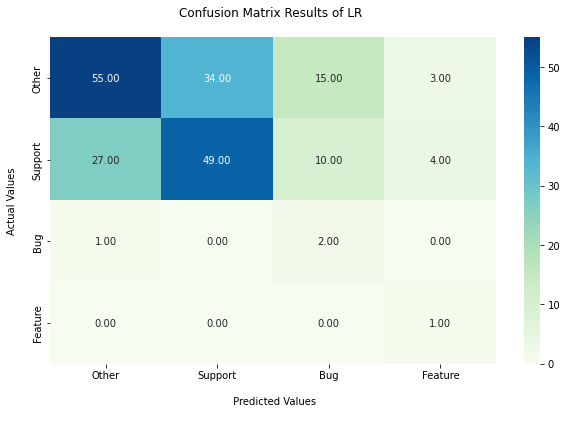

In [176]:
print("Confusion Matrix:")
confusion_matrix = metrics.confusionMatrix().toArray()
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix Results of LR \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(["Other", "Support", "Bug", "Feature"])
fx.yaxis.set_ticklabels(["Other", "Support", "Bug", "Feature"])
plt.show()

In [126]:
print("Accuracy: ", metrics.accuracy)
for idx, label in enumerate(labels):
  print("Precision for {}: {}".format(label, metrics.precision(idx)))
  print("Recall for {}: {}".format(label, metrics.recall(idx)))
  print("f1 score for {}: {}".format(label, metrics.fMeasure(float(idx), 1.0)))

Accuracy:  0.5323383084577115
Precision for Other: 0.6626506024096386
Recall for Other: 0.514018691588785
f1 score for Other: 0.5789473684210527
Precision for Support: 0.5903614457831325
Recall for Support: 0.5444444444444444
f1 score for Support: 0.5664739884393063
Precision for Bug: 0.07407407407407407
Recall for Bug: 0.6666666666666666
f1 score for Bug: 0.13333333333333333
Precision for Feature: 0.125
Recall for Feature: 1.0
f1 score for Feature: 0.2222222222222222


## Naive Bayes
Create a new pipeline for Naive Bayes

In [133]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes()

paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

cv_nb = CrossValidator(estimator=nb,
                    estimatorParamMaps=paramGrid_nb,
                    evaluator=MulticlassClassificationEvaluator(),
                    numFolds=5)

cvModelNB = cv_nb.fit(nlp_train)

In [134]:
# save the model to make future analysis easier (won't have to re-perform grid search)
from pyspark.ml.tuning import CrossValidatorModel
cvModel.write().overwrite().save("./trainedmodels/cvnb")
cvModel = CrossValidatorModel.load("./trainedmodels/cvnb")

In [135]:
# the parameters for the best model:
cvModelNB.bestModel.extractParamMap()

{Param(parent='NaiveBayes_8e7c9f2f7b75', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='NaiveBayes_8e7c9f2f7b75', name='labelCol', doc='label column name.'): 'label',
 Param(parent='NaiveBayes_8e7c9f2f7b75', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'multinomial',
 Param(parent='NaiveBayes_8e7c9f2f7b75', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='NaiveBayes_8e7c9f2f7b75', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='NaiveBayes_8e7c9f2f7b75', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='NaiveBayes_8e7c9f2f7b75', name='smoothing', doc

In [136]:
# get the accuracy metrics for the models. This is a list.
avgMetricsGridNB = cvModelNB.avgMetrics
print(avgMetricsGridNB)

[0.4203076125294336, 0.515048440907963, 0.5090659807673014, 0.507099240882805, 0.4955688372717284, 0.49973592877770945]


In [137]:
predictions_best_model_nb = cvModelNB.transform(nlp_validate)

In [138]:
accuracy = predictions_best_model_nb.filter(predictions_best_model_nb.label == predictions_best_model_nb.prediction).count() / float(predictions_best_model_nb.count())
roc_auc = evaluator.evaluate(predictions_best_model_nb)
print("Best Validation Accuracy Score (NB): {0:.4f}".format(accuracy))
print("Best Validation ROC-AUC (NB): {0:.4f}".format(roc_auc))

Best Validation Accuracy Score (NB): 0.5224
Best Validation ROC-AUC (NB): 0.4748


In [139]:
# generate the hits/misses
confusion_table_nb = predictions_best_model_nb.groupBy('label','prediction').count()

# Get the labels back from the model
from pyspark.ml.feature import IndexToString
t_labels = IndexToString(inputCol="label", outputCol="TargetLabel")
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"]) 

confusion_table_nb = t_labels.transform(confusion_table_nb)
confusion_table_nb = p_labels.transform(confusion_table_nb)
confusion_table_nb = confusion_table_nb.select(col("TargetLabel"), col("PredictionLabel"), col("count"))

#display the table with the confusion results
confusion_table_nb.show()

+-----------+---------------+-----+
|TargetLabel|PredictionLabel|count|
+-----------+---------------+-----+
|        Bug|          Other|    5|
|    Support|        Support|   69|
|      Other|        Support|   47|
|    Support|          Other|   14|
|        Bug|            Bug|    2|
|    Feature|        Support|    8|
|        Bug|        Support|   20|
|      Other|          Other|   34|
|      Other|            Bug|    2|
+-----------+---------------+-----+



Some More Metrics:

In [167]:
from pyspark.mllib.evaluation import MulticlassMetrics
predications_and_labels = predictions_best_model_nb.select(col('label'),col('prediction'))
labels = ["Other", "Support", "Bug", "Feature"]
metrics = MulticlassMetrics(predications_and_labels.rdd)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


For Some Reason this doesn't want to show the metrics for the "Feature" since it didn't have any values. There were 8 points that were all suggested to be Support, so it left it off the metrics below.

Confusion Matrix:


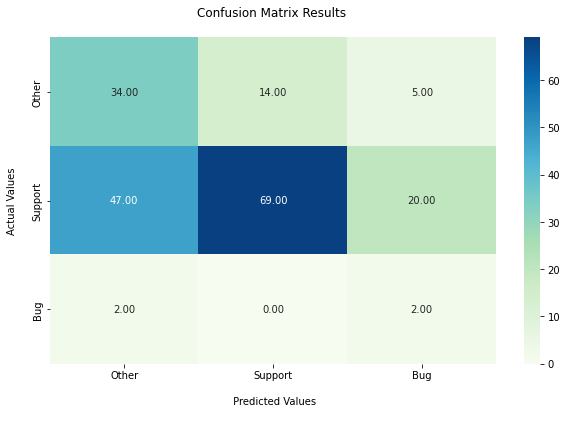

In [172]:
print("Confusion Matrix:")
confusion_matrix = metrics.confusionMatrix().toArray()
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix Results of NB \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(["Other", "Support", "Bug", "Feature"])
fx.yaxis.set_ticklabels(["Other", "Support", "Bug", "Feature"])
plt.show()

In [173]:
print("Accuracy: ", metrics.accuracy)
for idx, label in enumerate(labels):
  print("Precision for {}: {}".format(label, metrics.precision(idx)))
  print("Recall for {}: {}".format(label, metrics.recall(idx)))
  print("f1 score for {}: {}".format(label, metrics.fMeasure(float(idx), 1.0)))

Accuracy:  0.5223880597014925
Precision for Other: 0.40963855421686746
Recall for Other: 0.6415094339622641
f1 score for Other: 0.4999999999999999
Precision for Support: 0.8313253012048193
Recall for Support: 0.4791666666666667
f1 score for Support: 0.6079295154185023
Precision for Bug: 0.07407407407407407
Recall for Bug: 0.5
f1 score for Bug: 0.12903225806451613


Py4JJavaError: ignored

Download the files saved by the steps above

In [ ]:
#first zip the files
!zip -r /content/nlp.zip /content/nlp
!zip -r /content/trainedmodels.zip /content/trainedmodels

In [146]:
#then download
files.download('/content/nlp.zip')
files.download('/content/trainedmodels.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>